# Kernel-based Time-varying Regression - Part II

In previous tutorial, we learnt basic syntax and structure of **KTR** (or so called **BTVC**). We will shift the focus on creating a model with regressors. Note that the core idea of **KTR** is to create time-varying coefficients. This can also be an advantage of picking this model over other static regression coefficients model. 

Here in **Part I**, we will cover

1. KTR model structure with regression
2. Syntax to initialize, fit and predict a model with regressors
3. Visualization of regression coefficients
4. Advance Inputs and Customizing priors

In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTR
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.plot import get_orbit_style

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)
orbit_style = get_orbit_style()
plt.style.context(orbit_style)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(orbit.__version__)

1.0.16dev


## Model Structure

Our goal is to derive an additive form such that 

$$y_t = l_t + s_t + r_t + \epsilon_t,  ~ t = 1,\cdots, T,$$

where $y_t$ is the response variable, $l_t$ is the trend term,  $s_t$ is the seasonality term and $r_t$ is the regression term.

For details of how we we derive $l_t$ and $s_t$, please refer to **Part I**.

Recall in **KTR**, we express regression coefficients $\beta$ as such

$$\beta=Kb^T$$

where

- *knot matrix* $b$ with size $P\times J$  where each entry is a latent vairable  $b_{p, j}$ can be viewed as the "knots" from the perspective of spline regression and
$j$ is a time index such that $t_j \in [1, \cdots, T]$.
- *kernel matrix*  $K$  with size $T\times J$ where the $i$th row and $j$th element can be viewed as the noramlied weight $k(t_j, t) / \sum_{j=1}^{J} k(t_j, t)$

In regression, we generate the matrix $K$ with Gaussian kernel $k_\text{reg}$ as such:

$k_\text{reg}(t, t_j;\rho) = \exp ( -\frac{(t-t_j)^2}{2\rho^2}  ),$

where $\rho$ is the scale hyper-parameter.

## Data Simulation Module

In this example, we will use simulated data in order to have true regression coefficients for comparison.  We propose two set of simulations with three predictors:

- random walk
- sine-cosine like 

### Random Walk Simulated Dataset

In [4]:
def sim_data_seasonal(n, RS):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)
    # make the time varing coefs  
    tau = np.arange(1, n+1)/n
    data = pd.DataFrame({
        'tau': tau,
        'date': pd.date_range(start='1/1/2018', periods=n),
        'beta1': 2 * tau,
        'beta2': 1.01 + np.sin(2*pi*tau),
        'beta3': 1.01 + np.sin(4*pi*(tau-1/8)),
        'x1': np.random.normal(0, 10, size=n),
        'x2': np.random.normal(0, 10, size=n),
        'x3': np.random.normal(0, 10, size=n),
        'trend': np.cumsum(np.concatenate((np.array([1]), np.random.normal(0, 0.1, n-1)))),
        'error': np.random.normal(0, 1, size=n) #stats.t.rvs(30, size=n),#
    })
        
    data['y'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    return data

In [ ]:
def sim_data_rw(n, RS, p=3):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)

    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    beta = np.concatenate(
        [np.random.uniform(0.05, 0.12, size=(1,p)),
         np.random.normal(0.0, 0.01, size=(n-1,p))], 
            axis=0)
    beta = np.cumsum(beta, 0)

    # simulate regressors
    covariates = np.random.normal(0, 10, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
    beta_data = pd.DataFrame(beta, columns=beta_col)
    data = pd.concat([data, beta_data], axis=1)
        
    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))

    return data

In [5]:
rw_data = sim_data_rw(n=300, RS=8888, p=3)
rw_data.head(10)

,x1,x2,x3,beta1,beta2,beta3,y,date
0,1.11869,12.57944,-18.70548,0.08383,0.11804,0.10688,4.23824,2018-01-01
1,0.25149,5.30067,8.97456,0.08158,0.11665,0.11608,6.76230,2018-01-02
2,-12.53590,2.13434,4.22410,0.08384,0.11274,0.12169,4.57635,2018-01-03
3,-6.83038,3.09457,-1.92619,0.06779,0.11135,0.12628,4.49756,2018-01-04
4,-3.37015,3.89962,-3.08311,0.08633,0.09988,0.13899,5.23037,2018-01-05
5,-3.36446,-4.18615,13.14925,0.07620,0.10859,0.14255,6.10277,2018-01-06
6,-3.66356,-14.79541,-1.73128,0.09153,0.09901,0.15621,3.28499,2018-01-07
7,7.20599,-5.62337,-11.80655,0.10095,0.09951,0.16008,2.52902,2018-01-08
8,-3.64366,3.79963,-1.39817,0.10064,0.08795,0.16389,4.90898,2018-01-09
9,9.22233,1.69517,-0.89649,0.09850,0.08597,0.17241,5.52978,2018-01-10


### Sine-Cosine Like Simulated Dataset

In [17]:
sc_data = sim_data_seasonal(n=1000, RS=2021)
sc_data.head(10)

,tau,date,beta1,beta2,beta3,x1,x2,x3,trend,error,y
0,0.00100,2018-01-01,0.00200,1.01628,0.01008,14.88609,-18.30869,8.02113,1.00000,-0.42452,-18.92072
1,0.00200,2018-01-02,0.00400,1.02257,0.01032,6.76011,-12.45446,8.42241,0.99524,-0.17994,-12.80153
2,0.00300,2018-01-03,0.00600,1.02885,0.01071,-4.18451,6.37632,-2.65741,0.99647,0.56875,7.07545
3,0.00400,2018-01-04,0.00800,1.03513,0.01126,-8.06521,-5.05428,-14.34493,0.89220,0.18640,-5.27152
4,0.00500,2018-01-05,0.01000,1.04141,0.01197,5.55876,-5.59333,4.47058,0.67806,-0.46691,-6.18275
5,0.00600,2018-01-06,0.01200,1.04769,0.01284,-7.05504,2.14293,1.50937,0.50218,1.00234,3.18218
6,0.00700,2018-01-07,0.01400,1.05397,0.01387,11.30858,-4.28970,0.56315,0.49856,0.90866,-3.44642
7,0.00800,2018-01-08,0.01600,1.06024,0.01505,6.45002,13.52961,7.73681,0.52584,0.22622,14.79055
8,0.00900,2018-01-09,0.01800,1.06652,0.01639,1.06414,14.28461,19.57613,0.36653,-1.14237,14.43242
9,0.01000,2018-01-10,0.02000,1.07279,0.01789,4.22155,-20.16490,-8.78261,0.31014,0.53463,-21.17074


## Fitting a Model with Regressors

Let's derive some metadata for fitting purpose.

In [6]:
# num of predictors
p = 3
regressor_col = ['x{}'.format(pp) for pp in range(1, p + 1)]
response_col = 'y'
date_col='date'

Here, we need to supply additional args to describe the regressors.

In [7]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    # in this exercise, we don't have time-varying level
    level_segments=1,
    regressor_col=regressor_col,
#     regressor_init_knot_scale=[10.0] * len(regressor_col),
#     regressor_knot_scale=[2.0] * len(regressor_col),
    regression_segments=5,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    estimator='pyro-svi'
)

After the initialization, the fit-and-predict would be similar to the previous models. And now you should expect a regression component reported in prediction if you specify `decompose=True`.

In [8]:
ktr.fit(df=rw_data)
ktr.predict(df=rw_data, decompose=True).head(5)

INFO:root:Guessed max_plate_nesting = 1


,date,prediction_2.5,prediction,prediction_97.5,trend_2.5,trend,trend_97.5,seasonality_2.5,seasonality,seasonality_97.5,regression_2.5,regression,regression_97.5
0,2018-01-01,-3.78533,2.23608,7.85089,4.96046,5.09548,5.24118,0.00000,0.00000,0.00000,-5.08214,-3.18622,-1.35146
1,2018-01-02,1.16197,7.38570,12.73365,4.96046,5.09564,5.24048,0.00000,0.00000,0.00000,0.97636,1.83282,2.72771
2,2018-01-03,-1.83051,4.61170,10.63958,4.96046,5.09579,5.23978,0.00000,0.00000,0.00000,-1.65653,-0.41614,0.54258
3,2018-01-04,-2.84021,3.86459,10.58062,4.96046,5.09595,5.23908,0.00000,0.00000,0.00000,-1.61695,-0.99904,-0.48709
4,2018-01-05,-2.00187,4.61981,10.67584,4.96046,5.09610,5.23849,0.00000,0.00000,0.00000,-1.37355,-0.84436,-0.41621


## Visualization of regression coefficient curves

First, we can leverage `get_regression_coefs` to extract coefficients with intervals by supplying argument `include_ci=True`.

In [10]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

In [11]:
coef_mid.head(5)

,date,x1,x2,x3
0,2018-01-01,0.10081,0.01832,0.18763
1,2018-01-02,0.10124,0.01777,0.18752
2,2018-01-03,0.10168,0.01721,0.18741
3,2018-01-04,0.10213,0.01664,0.18729
4,2018-01-05,0.10259,0.01606,0.18717


Let's overlay the estimate with the true coefficients.

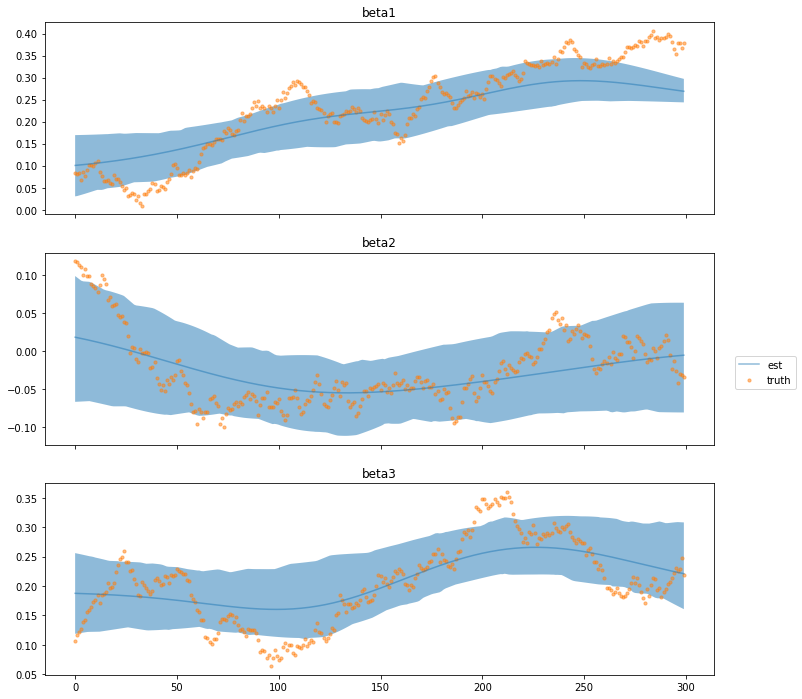

In [12]:
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", alpha=0.5)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.5)
    axes[idx].scatter(x, rw_data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "", s=10, alpha=0.5)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1,0.5));

You can also plot coefficients with the built-in function `plot_regression_coefs` from the class.

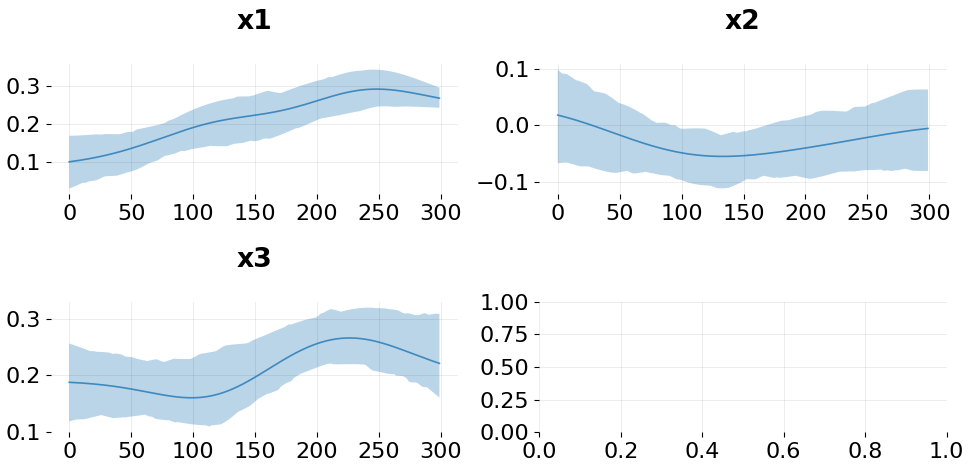

In [14]:
ktr.plot_regression_coefs(figsize=(10, 5), include_ci=True);

These type of time-varying coefficients detection problems are not new. Bayesian approach such as the  R packages Bayesian Structural Time Series (a.k.a **BSTS**) by Scott and Varian (2014) and **tvReg** Isabel Casas and Ruben Fernandez-Casal (2021). Other frequentist approach such as Wu and Chiang (2000).

For further studies on benchmarking coefficients detection, Ng, Wang and Dai (2021) provides details by comparing **KTR** with other popular time-varying coefficients methods where we find that the **KTR** demonstrates superior performance in the random walk data simulation. 

## Advance Inputs and Customizing priors

To demonstrate how priors and ways to specify number of knots, we move onto the sine-cosine like dataset. In this dataset, the fitting is more tricky since there could be some better way to define number and position of the knots as you may see there are obvious "change points" within the sine-cosine like curves. Here are a few arguments we can leverage:

1. We can use `regressor_init_knot_loc` to define the prior mean of the knot value. e.g. in this case, we don't have too much knowledge so we put zeros.
2. Knowing the range is actually much bigger, we use the `regressor_init_knot_scale` and `regressor_knot_scale` to tune the prior sd of the global mean of the knot and the sd of each knot from the global mean respectively.
3. To allow more "change points" to be detected, we increase the segments (where we put knots in the edges by `regression_segments`.

In [25]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    
    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[2.0] * len(regressor_col),
    regressor_knot_scale=[1.0] * len(regressor_col),
    regression_segments=10,

    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    estimator='pyro-svi',
)
ktr.fit(df=sc_data)

INFO:root:Guessed max_plate_nesting = 1


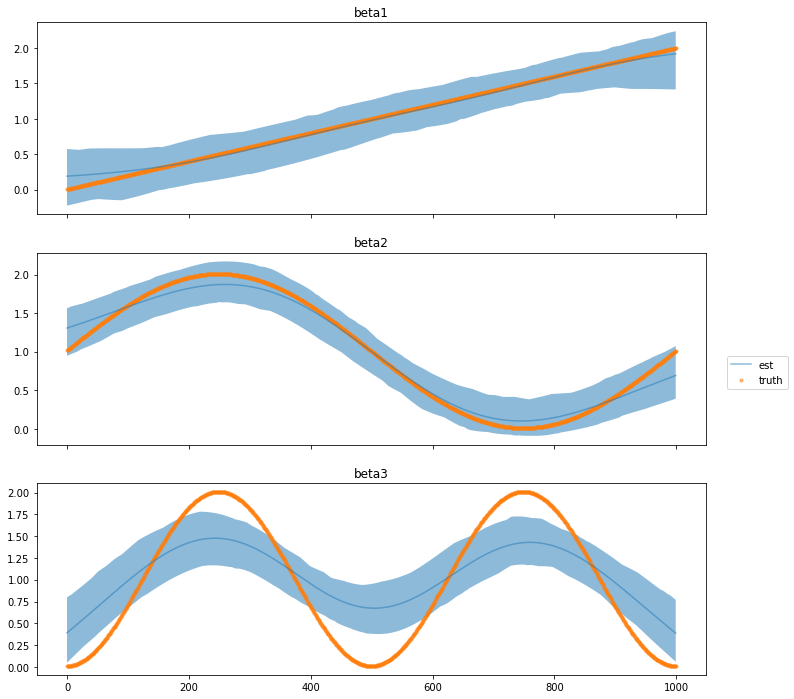

In [26]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", alpha=0.5)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.5)
    axes[idx].scatter(x, sc_data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "", s=10, alpha=0.5)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1, 0.5));

You can also visualize the knots again by the `plot_regression_coefs` function with `with_knot=True` this time.

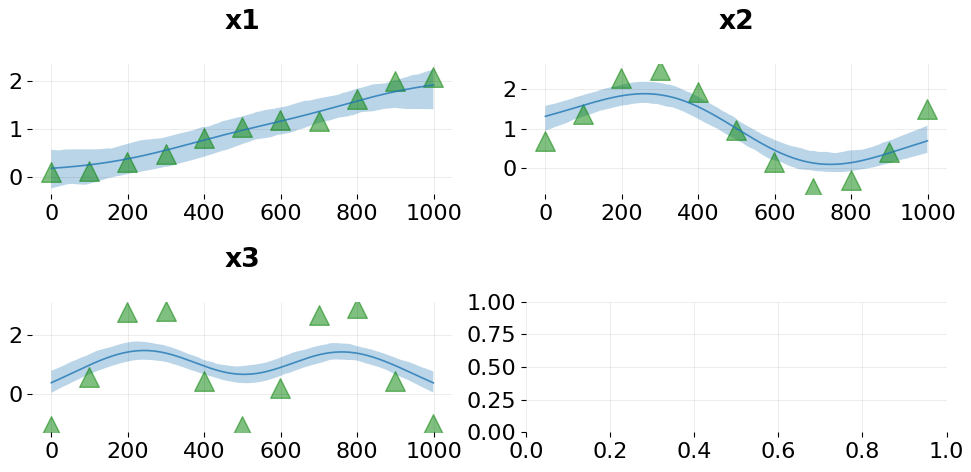

In [27]:
ktr.plot_regression_coefs(with_knot=True, figsize=(10, 5), include_ci=True);

There are more ways to define knots for regression as well as seasonality and trend (a.k.a levels).  We will cover them in next chapter. 